## ST-DBSCAN Algorithm

The second algorithm used is ST-DBSCAN, a density based clustering algorithm, an extension of DBSCAN (Density-Based Spatial Clustering of Applications with Noise). This algorithm aidentifies cluster based on a given spatial and temporal threshold as well as the minimun number of neighbours.  

This notebook uses the python implementation of ST-DBSCAN algorithm available at https://github.com/gitAtila/ST-DBSCAN.

In [3]:
#importing necessary packages
from geofeather import to_geofeather, from_geofeather
from matplotlib import pyplot as plt
import feather
import numpy as np
import pandas as pd
import folium

### Functions

Following are the functions used in this notebook:

ST_DBSCAN function creates clusters iteratively and  retrieve_neighbors function retrieves the neighbour points. This function takes dataframe or geodataframe as input and returns a dataframe with the cluster id added for each row. The noise is marked as -1.  

In [4]:
## functions imported from source: https://github.com/gitAtila/ST-DBSCAN ##
import math
from datetime import timedelta
from geopy.distance import great_circle
"""
INPUTS:
    df={o1,o2,...,on} Set of objects
    spatial_threshold = Maximum geographical coordinate (spatial) distance value (Eps1)
    temporal_threshold = Maximum non-spatial distance value (Eps2)
    min_neighbors = Minimun number of points within Eps1 and Eps2 distance
OUTPUT:
    C = {c1,c2,...,ck} Set of clusters
"""
def ST_DBSCAN(df, spatial_threshold, temporal_threshold, min_neighbors):
    cluster_label = 0
    NOISE = -1
    UNMARKED = 777777
    stack = []

    # initialize each point with unmarked
    df['cluster'] = UNMARKED
    
    # for each point in database
    for index, point in df.iterrows():
        if df.loc[index]['cluster'] == UNMARKED:
            neighborhood = retrieve_neighbors(index, df, spatial_threshold, temporal_threshold)
            
            if len(neighborhood) < min_neighbors:
                df.at[index, 'cluster'] = NOISE

            else: # found a core point
                cluster_label = cluster_label + 1
                df.at[index, 'cluster'] = cluster_label# assign a label to core point

                for neig_index in neighborhood: # assign core's label to its neighborhood
                    df.at[neig_index, 'cluster'] = cluster_label
                    stack.append(neig_index) # append neighborhood to stack
                
                while len(stack) > 0: # find new neighbors from core point neighborhood
                    current_point_index = stack.pop()
                    new_neighborhood = retrieve_neighbors(current_point_index, df, spatial_threshold, temporal_threshold)
                    
                    if len(new_neighborhood) >= min_neighbors: # current_point is a new core
                        for neig_index in new_neighborhood:
                            neig_cluster = df.loc[neig_index]['cluster']
                            if (neig_cluster != NOISE) & (neig_cluster == UNMARKED): 
                                # TODO: verify cluster average before add new point
                                df.at[neig_index, 'cluster'] = cluster_label
                                stack.append(neig_index)
    return df


def retrieve_neighbors(index_center, df, spatial_threshold, temporal_threshold):
    neigborhood = []

    center_point = df.loc[index_center]

    # filter by time 
    min_time = center_point['date_time'] - timedelta(minutes = temporal_threshold)
    max_time = center_point['date_time'] + timedelta(minutes = temporal_threshold)
    df = df[(df['date_time'] >= min_time) & (df['date_time'] <= max_time)]

    # filter by distance
    for index, point in df.iterrows():
        if index != index_center:
            distance = great_circle((center_point['latitude'], center_point['longitude']), (point['latitude'], point['longitude'])).meters
            if distance <= spatial_threshold:
                neigborhood.append(index)

    return neigborhood

This function creates a scatterplot of the clusters colored by the cluster id.

In [50]:
#function for the scatterplot of clusters
def dfScatter(df, xcol='longitude', ycol='latitude', catcol='cluster'):
    fig, ax = plt.subplots()
    categories = np.unique(df[catcol])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))

    df["Color"] = df[catcol].apply(lambda x: colordict[x])
    ax.scatter(df[xcol], df[ycol], c=df.Color, cmap = 'jet')
    return fig

The following two functions are for plotting the clusters on overlaid on a base map and to provide popo ups of cluster id.

In [35]:
def makepopup(t):
        return str(t)

In [36]:
#function to plot the clusters overlaid on a map
def map(m, data, value = 'cluster', lat = 'latitude', lng = 'longitude', col ='#f09205'):

    lats = data[lat]
    lngs = data[lng]

    avg_lat = sum(lats) / len(lats)
    avg_lngs = sum(lngs) / len(lngs)

    latlngs = []
    value = data[value]
    color = [col]*len(data)
    for lat,lng,c,v in zip(lats, lngs, color, value):
        folium.CircleMarker([lat,lng], color = c, radius =3, fill = c, popup = makepopup(v)).add_to(m)
        latlngs.append([lat,lng])


    m.fit_bounds(latlngs)

### Data Import

The enviroCar tracks data for Mönchengladbach city is stored in geofeather format which is imported into the notebook as a geodataframe. 

In [52]:
#importing tracks data saved in 
track_df = from_geofeather('Data/MNCHNGLDBCH_500.feather')
# track_df.columns

In [8]:
df = track_df.dropna(subset = ['time'])
len(df)

114045

The input must have the columns: 'latitude', 'longitude' and 'date_time'. These columns are extracted from the tracks geodataframe and stored in a new one. The time field should be converted to datetime object.  

In [9]:
df['latitude'] = df['geometry'].apply(lambda coord: coord.y)
df['longitude'] = df['geometry'].apply(lambda coord: coord.x)
df['date_time'] = pd.to_datetime(df['time']) #convert to datetime object

df_table = df[['latitude', 'longitude', 'date_time']].copy()
df_table.head()

latitude  longitude           date_time
0  51.203280   6.414546 2018-07-11 06:07:23
1  51.203085   6.415119 2018-07-11 06:07:28
2  51.202986   6.415637 2018-07-11 06:07:33
3  51.202912   6.416147 2018-07-11 06:07:38
4  51.202825   6.416707 2018-07-11 06:07:43

### Clustering 

The clustering algorithm is called in this step. For this, the spatial and temporal thresholds are set and the minimum number of neighbours is provided.  

In [10]:
%%time
#setting thresholds
spatial_threshold = 100 # meters
temporal_threshold = 1  # minutes
min_neighbors = 40
#clustering function call
df_clustering = ST_DBSCAN(df_table, spatial_threshold, temporal_threshold, min_neighbors)
df_clustering.head()

Wall time: 15min 5s


latitude  longitude           date_time  cluster
0  51.203280   6.414546 2018-07-11 06:07:23       -1
1  51.203085   6.415119 2018-07-11 06:07:28       -1
2  51.202986   6.415637 2018-07-11 06:07:33       -1
3  51.202912   6.416147 2018-07-11 06:07:38       -1
4  51.202825   6.416707 2018-07-11 06:07:43       -1

In [11]:
df_clustering.groupby(['cluster']).count()

latitude  longitude  date_time
cluster                                
-1         107712     107712     107712
 1             42         42         42
 2             51         51         51
 3             42         42         42
 4             47         47         47
...           ...        ...        ...
 98            43         43         43
 99            72         72         72
 100          109        109        109
 101           49         49         49
 102          102        102        102

[103 rows x 3 columns]

The output is filtered to remove the noise.

In [12]:
df_clustering_filter = df_clustering[df_clustering['cluster'] != -1]

In [13]:
df_clustering_filter['cluster'].nunique() #number of clusters

102

<ipython-input-42-9aa326f8ca27>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Color"] = df[catcol].apply(lambda x: colordict[x])


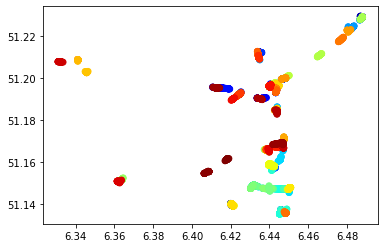

In [44]:
#function call for scatterplot
fig = dfScatter(df_clustering_filter)

In [37]:
#function call for map
m = folium.Map(tiles = 'Stamen Terrain', zoom_start=12)
d = map(m, df_clustering_filter)
m

The output of clustering algorithm is saved in feather data format.

In [24]:
#conversion to feather format
df_clustering_copy = df_clustering.reset_index(inplace = True)
df_clustering.to_feather('Data/stdbscan500_100_1_40.feather')